# R-CNN for object detection ont hte base of VGG16
Dataset PASCAL VOC 2005

In [104]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import cv2
from tensorflow.image import non_max_suppression
import numpy as np

## Selective search

In [77]:
img_path = 'VOC2005_1\PNGImages\ETHZ_motorbike-testset\motorbikes114.png'
img = cv2.imread(img_path)

In [78]:
def generate_ROI(image):
	ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
	ss.setBaseImage(image)
	ss.switchToSelectiveSearchFast()
	rects = ss.process()
	proposedRects= []
	for (x, y, w, h) in rects:
		proposedRects.append((x, y, x + w, y + h))
	return proposedRects   

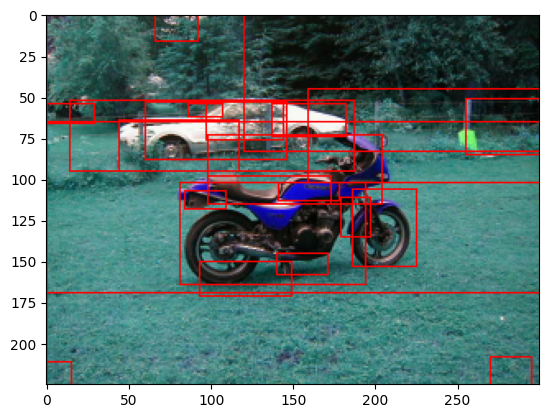

In [79]:
proposedRects = generate_ROI(img)
img2 = img.copy()
for i in range(0,len(proposedRects), 20):
    x1, y1, x2, y2 = proposedRects[i]
    img2 = cv2.rectangle(img2, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=1) 
plt.imshow(img2)

In [80]:
def compute_iou(boxA, boxB):
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])

	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

	iou = interArea / float(boxAArea + boxBArea - interArea)

	return iou

## Classification model

In [81]:
model = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    name="vgg16",
)


In [82]:
def classification_result(model, img):
    img = img_to_array(img)
    img = cv2.resize(img, (224, 224))
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_input(img)
    yhat = model.predict(img)
    label = decode_predictions(yhat)
    label = label[0][0]
    object_class, confidence = label[1], label[2]
    return object_class, confidence   

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
moped 0.74784535


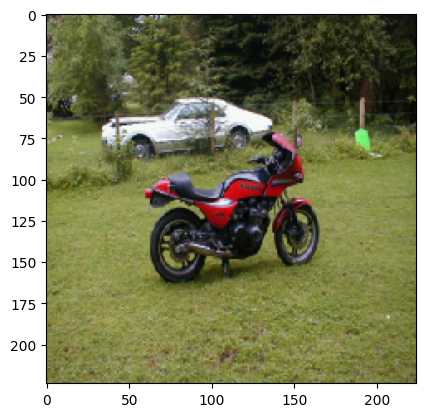

In [83]:
img = load_img(img_path,  target_size=(224, 224))
plt.imshow(img)
object_class, confidence  = classification_result(model, img)
print(object_class, confidence)

## ROI classification

In [84]:
def get_boxes_with_labels(image, proposedRects, model):
    labeled_boxes = []
    for rect in proposedRects:
        x1, y1, x2, y2 = rect
        rect_img = image.crop(rect)
        object_class, confidence  = classification_result(model, rect_img)
        labeled_boxes.append([object_class, confidence, rect])
    return labeled_boxes   

In [85]:
box = proposedRects[123]


In [86]:
labeled_boxes = get_boxes_with_labels(img, proposedRects, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Remove boxes where no mopeds

In [100]:
filtered_labeled_boxes = [labeled_box for labeled_box in labeled_boxes if ('moped' in labeled_box[0])]
len(filtered_labeled_boxes)

12

## Non-maximum supression
Remove overlapped boxes

In [107]:
boxes = []
scores = []
for i in range(len(filtered_labeled_boxes)):
    boxes.append(filtered_labeled_boxes[i][2])
    scores.append(filtered_labeled_boxes[i][1])
boxes, scores = np.array(boxes), np.array(scores)
print(boxes.shape, scores.shape)

(12, 4) (12,)


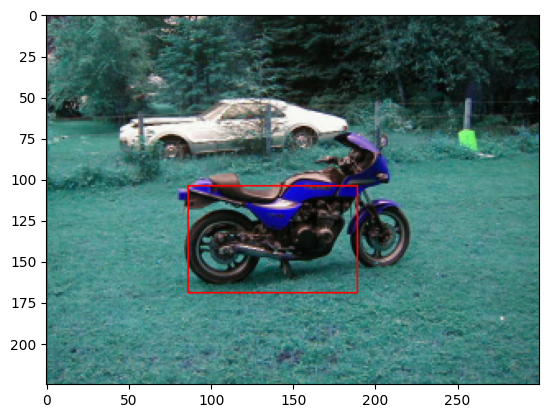

In [115]:
selected_idx = non_max_suppression(boxes, scores, max_output_size=20, iou_threshold=0.5)
res_img = cv2.imread(img_path)
for i in selected_idx:
    x1, y1, x2, y2 = boxes[int(i), :].tolist()
    res_img = cv2.rectangle(res_img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=1) 
plt.imshow(res_img)